<a href="https://colab.research.google.com/github/Manjaka97/Pneumonia-Detector/blob/master/Pneumonia_Detection_Resnet18_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Workspace Preparation

In [0]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os
import copy

plt.ion()   # interactive mode

In [18]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


Let's make sure we are using the GPU provided by Google Colab.

In [19]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


The dataset is in Google Drive. Since we already mounted it, we can access it directly from Colab.

In [20]:
print(os.listdir('../gdrive/My Drive/Datasets/chest_xray'))

['train', 'test', 'val', '.DS_Store']


# Image Preprocessing

Since we are going to use Transfer Learning with Resnet18, we need to preprocess all the images to be compatible with the model.


*   Resnet18 expects 3 channels (rgb), but we only have grayscale images
*   All images must be at least 224 x 224 in size
*   All images have to be loaded in to a range of [0, 1]
*   All images must be normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225]



In [0]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.RandomRotation(20),
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '../gdrive/My Drive/Datasets/chest_xray'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) 
                  for x in ['train', 'val', 'test']}

dataloaders = {'train': torch.utils.data.DataLoader(image_datasets['train'], batch_size = 4, shuffle=True), 
               'val': torch.utils.data.DataLoader(image_datasets['val'], batch_size = 1, shuffle=True), 
               'test': torch.utils.data.DataLoader(image_datasets['test'], batch_size = 1, shuffle=True)}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

# Visualization

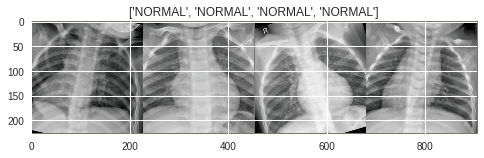

In [22]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

# Model Preparation
First, let's define a function to train the model.

In [0]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        epoch_start = time.time()
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            epoch_length = epoch_start - time.time()
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            print('Epoch training duration: {:.0f}m {:.0f}s'.format(
                epoch_length // 60, epoch_length % 60))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

We also need a function to visualize some predictions.

In [0]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {} - ground truth: {}'.format(class_names[preds[j]],class_names[labels[0]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

# Model Finetuning
We are going to use a pretrained ResNet18 model. Let's have a look at its architecture.

In [26]:
model = models.resnet18(pretrained=True)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

We'll re-train all the layers of our ResNet18 model, but we'll start with saved weights from the same model that had half the layers trained.

In [27]:
# Uncomment this to freeze half the layers
#i = 0
#for child in model.children():
#  i += 1
#  if i < 7:
#      for param in child.parameters():
#         param.requires_grad = False

# Uncomment this to freeze all layers
#for child in model.children():
#  for param in child.parameters():
#    param.requires_grad = False

num_features = model.fc.in_features
# Replace last layer
model.fc = nn.Linear(num_features, len(class_names))

# Uncomment this to use last best model with saved weights
model.load_state_dict(torch.load('../gdrive/My Drive/Models/Pneumonia Detection/resnet18-1'))
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [0]:
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Model Training

In [29]:
model = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=16)

Epoch 0/15
----------
train Loss: 0.1403 Acc: 0.9595
Epoch training duration: -12m 5s
val Loss: 0.2238 Acc: 0.8750
Epoch training duration: -12m 4s

Epoch 1/15
----------
train Loss: 0.1031 Acc: 0.9691
Epoch training duration: -6m 22s
val Loss: 0.8426 Acc: 0.5625
Epoch training duration: -6m 22s

Epoch 2/15
----------
train Loss: 0.0938 Acc: 0.9712
Epoch training duration: -6m 23s
val Loss: 0.0959 Acc: 1.0000
Epoch training duration: -6m 22s

Epoch 3/15
----------
train Loss: 0.0746 Acc: 0.9776
Epoch training duration: -6m 25s
val Loss: 0.2211 Acc: 0.8750
Epoch training duration: -6m 25s

Epoch 4/15
----------
train Loss: 0.0673 Acc: 0.9808
Epoch training duration: -6m 25s
val Loss: 1.2380 Acc: 0.5625
Epoch training duration: -6m 24s

Epoch 5/15
----------
train Loss: 0.0614 Acc: 0.9818
Epoch training duration: -6m 26s
val Loss: 0.6815 Acc: 0.6875
Epoch training duration: -6m 25s

Epoch 6/15
----------
train Loss: 0.0672 Acc: 0.9849
Epoch training duration: -6m 25s
val Loss: 0.1174 Acc

# Result Visualizaiton

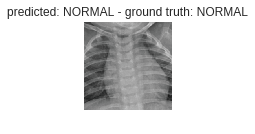

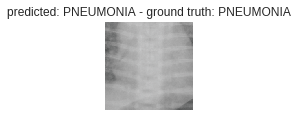

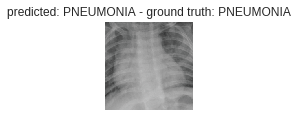

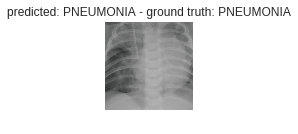

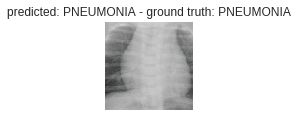

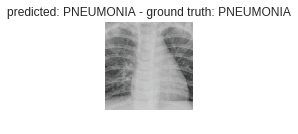

In [30]:
visualize_model(model)

Let's save our model.

In [0]:
torch.save(model.state_dict(), '../gdrive/My Drive/Models/Pneumonia Detection/resnet18-2.pth')

Let's define a function to test the model on the test set.

In [0]:
def test_model():
    running_correct = 0.0
    running_total = 0.0
    true_labels = []
    pred_labels = []
    with torch.no_grad():
        for data in dataloaders['test']:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            true_labels.append(labels.item())
            outputs = model(inputs)
            _, preds = torch.max(outputs.data, 1)
            pred_labels.append(preds.item())
            running_total += labels.size(0)
            running_correct += (preds == labels).sum().item()
        acc = running_correct/running_total
    return (true_labels, pred_labels, running_correct, running_total, acc)

In [34]:
true_labels, pred_labels, running_correct, running_total, acc = test_model()
print("Total Correct: {}, Total Test Images: {}".format(running_correct, running_total))
print("Test Accuracy: ", acc)

Total Correct: 563.0, Total Test Images: 624.0
Test Accuracy:  0.9022435897435898


We get an accuracy of 90.2%. Let's see the confusion matrix.

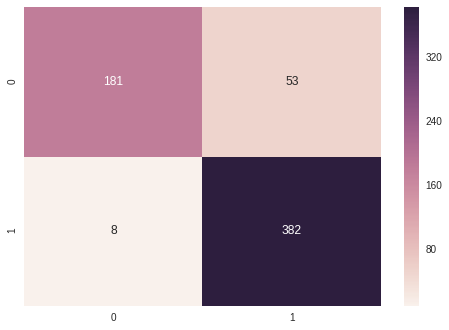

In [35]:
cm = confusion_matrix(true_labels, pred_labels)
tn, fp, fn, tp = cm.ravel()
ax = sns.heatmap(cm, annot=True, fmt="d")

In [0]:
recall = tp/(tp + fn)
precision = tp/((tp + fp))
f1_score = 2 * (recall * precision)/(precision + recall)

In [37]:
print('F1 Score: ', f1_score)
print('Precision: ', precision)
print('Recall: ', recall)

F1 Score:  0.926060606060606
Precision:  0.8781609195402299
Recall:  0.9794871794871794
